In [1]:
import pandas as pd
from IPython.display import display
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import mannwhitneyu
import gc
import numpy as np

In [2]:
# df = pd.read_csv("c:\\data\\e-commerce\\2019-Oct.csv", usecols=['event_time', 'event_type', 'product_id', 'brand', 'category_code', 'price', 'user_id', 'user_session'])
# df.head(2)

In [3]:
# df['category_code'] = df['category_code'].astype('category')
# df['category_code'] = df['category_code'].cat.add_categories('unknown.')
# df['category_code'].fillna('unknown.', inplace=True)

# df['general_category'] = df['category_code'].apply(lambda x: x.split('.')[0])
# display(df.head(2))

In [4]:
# df['user_session'] = df['user_session'].astype('category').cat.codes
# df.head()

In [5]:
# df.head(2)

In [6]:
# # datetime 처리
# df['event_time'] = pd.to_datetime(df['event_time'])
# df['date'] = df['event_time'].dt.date

# # 사용자별, 시간순 정렬
# df = df.sort_values(['user_id', 'event_time'])

# # 구매 발생 플래그
# df['is_purchase'] = df['event_type'] == 'purchase'

# # 하루 단위 기준 세션 초기화
# df['daily_session'] = df['user_id'].astype(str) + '_' + df['date'].astype(str)

# # 구매 발생 시 세션 쪼개기: 구매 이후는 새로운 세션으로
# def split_on_purchase(group):
#     session_id = []
#     counter = 0
#     for is_p in group['is_purchase']:
#         session_id.append(counter)
#         if is_p:
#             counter += 1
#     return session_id

# # 사용자 + 날짜별로 쪼개서 세션 나누기
# df['session_split_id'] = df.groupby(['user_id', 'date']).apply(split_on_purchase).explode().values

# df['custom_session'] = (
#     df['user_id'].astype(str) + '_' +
#     df['date'].astype(str) + '_' +
#     df['session_split_id'].astype(str)
# )
# df.head(2)


In [7]:
# df.to_csv("c:\\data\\e-commerce\\custom_session.csv", index=False) # event_time, event_type, product_id, category_code, brand, price, user_id, user_session, general_category, buy, date, is_purchase, daily_session, session_split_id, custom_session
custom_session = pd.read_csv("c:\\data\\e-commerce\\custom_session.csv", usecols=['event_time', 'event_type', 'product_id', 'category_code', 'brand', 'price', 'user_id', 'general_category', 'buy', 'custom_session']);custom_session.head(2)
custom_session.head(2)

,event_time,event_type,product_id,category_code,brand,price,user_id,general_category,buy,custom_session
0,2019-10-23 20:04:08+00:00,view,7002639,kids.carriage,bumbleride,769.65,33869381,kids,0,33869381_2019-10-23_0
1,2019-10-13 00:13:46+00:00,view,10600284,unknown.,NaN,0.00,64078358,unknown,0,64078358_2019-10-13_0


In [8]:
buy_sessions = custom_session[custom_session['event_type'] == 'purchase']['custom_session'].unique()

buy_log = custom_session[custom_session['custom_session'].isin(buy_sessions)]
not_buy_log = custom_session[~custom_session['custom_session'].isin(buy_sessions)]
custom_session['buy'] = custom_session['custom_session'].isin(buy_log['custom_session']).astype(int)
custom_session.head(2)

,event_time,event_type,product_id,category_code,brand,price,user_id,general_category,buy,custom_session
0,2019-10-23 20:04:08+00:00,view,7002639,kids.carriage,bumbleride,769.65,33869381,kids,0,33869381_2019-10-23_0
1,2019-10-13 00:13:46+00:00,view,10600284,unknown.,NaN,0.00,64078358,unknown,0,64078358_2019-10-13_0


In [9]:
median_price_category = custom_session.groupby('general_category')['price'].median().to_dict()
custom_session['relative_price'] = custom_session['price'] / custom_session['general_category'].map(median_price_category)
custom_session.head(2)

,event_time,event_type,product_id,category_code,brand,price,user_id,general_category,buy,custom_session,relative_price
0,2019-10-23 20:04:08+00:00,view,7002639,kids.carriage,bumbleride,769.65,33869381,kids,0,33869381_2019-10-23_0,6.986022
1,2019-10-13 00:13:46+00:00,view,10600284,unknown.,NaN,0.00,64078358,unknown,0,64078358_2019-10-13_0,0.000000


In [10]:
custom_session['custom_session'] = custom_session['custom_session'].astype('category').cat.codes
custom_session.head(2)

,event_time,event_type,product_id,category_code,brand,price,user_id,general_category,buy,custom_session,relative_price
0,2019-10-23 20:04:08+00:00,view,7002639,kids.carriage,bumbleride,769.65,33869381,kids,0,431,6.986022
1,2019-10-13 00:13:46+00:00,view,10600284,unknown.,NaN,0.00,64078358,unknown,0,42508,0.000000


In [11]:
def log_dictionary(df):

    df = df.sort_values(['user_id', 'event_time'])
    df['event_time'] = pd.to_datetime(df['event_time'])

    session_data = []

    for session, group in df.groupby('custom_session'):
        group = group.sort_values('event_time')

        times = group['event_time'].tolist()
        time_since_start = [(t - times[0]).total_seconds() for t in times]
        time_since_prev = [0] + [(times[i] - times[i-1]).total_seconds() for i in range(1, len(times))]

        events = []
        for _, row in group.iterrows():
            if row['event_type'] == 'purchase':
                continue  # 구매 제외
            
            events.append({
                "event_type": row["event_type"],
                "product_id": row["product_id"],
                "category_code": row["category_code"] if pd.notna(row["category_code"]) else "unknown.",
                "general_category": row["general_category"] if pd.notna(row["general_category"]) else "unknown",
                "brand": row["brand"] if pd.notna(row["brand"]) else "unknown",
                "price": row["price"],
                "relative_price": row["relative_price"],
                "time_since_start": time_since_start[len(events)],
                "time_since_prev": time_since_prev[len(events)]
            })

        session_data.append({
            "session": session,
            "event": events,
            "buy": int(group["buy"].max())
        })

    return pd.DataFrame(session_data)

In [ ]:
log_dict = log_dictionary(custom_session)

In [ ]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None) 

# pd.reset_option("display.max_colwidth")
# pd.reset_option("display.max_rows")
# pd.reset_option("display.max_columns")

In [ ]:
display(log_dict.head(3))

,session,event,buy
0,0,"[{'event_type': 2, 'product_id': 22200103, 'category_code': 'unknown', 'general_category': 'unknown', 'brand': 'unknown', 'price': 15.77, 'relative_price': 0.17504717504717504, 'time_since_start': 0.0, 'time_since_prev': 0}]",0
1,1,"[{'event_type': 2, 'product_id': 6902133, 'category_code': 'furniture.living_room.chair', 'general_category': 'furniture', 'brand': 'joie', 'price': 143.89, 'relative_price': 0.800857126954973, 'time_since_start': 0.0, 'time_since_prev': 0}, {'event_type': 2, 'product_id': 6902133, 'category_code': 'furniture.living_room.chair', 'general_category': 'furniture', 'brand': 'joie', 'price': 143.89, 'relative_price': 0.800857126954973, 'time_since_start': 41.0, 'time_since_prev': 41.0}, {'event_type': 2, 'product_id': 6902303, 'category_code': 'furniture.living_room.chair', 'general_category': 'furniture', 'brand': 'joie', 'price': 111.46, 'relative_price': 0.6203595480603329, 'time_since_start': 373.0, 'time_since_prev': 332.0}, {'event_type': 2, 'product_id': 6902303, 'category_code': 'furniture.living_room.chair', 'general_category': 'furniture', 'brand': 'joie', 'price': 111.46, 'relative_price': 0.6203595480603329, 'time_since_start': 387.0, 'time_since_prev': 14.0}]",0


In [ ]:
def category_code(events):
    for event in events:
        if event['category_code'] == 'unknown.':
            event['category_code'] = 'unknown'
    return events
log_dict['event'] = log_dict['event'].apply(category_code)

In [ ]:
from sklearn.preprocessing import LabelEncoder
le_event = LabelEncoder()
le_event.fit(custom_session['event_type'].unique())
le_event.classes_

array(['cart', 'purchase', 'view'], dtype=object)

In [ ]:
def encode_event_type(events):
    for event in events:
        event['event_type'] = le_event.transform([event['event_type']])[0]
    return events

log_dict['event'] = log_dict['event'].apply(encode_event_type)

In [ ]:
log_dict.head(2)

,session,event,buy
0,0,"[{'event_type': 2, 'product_id': 22200103, 'ca...",0
1,1,"[{'event_type': 2, 'product_id': 6902133, 'cat...",0


In [ ]:
df = log_dict.copy()

In [ ]:
# 전체 파이프라인: 데이터 파싱 -> vocabs -> tf.data -> Transformer 모델 -> 학습
import ast
import json
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# 1) 파싱
# columns = ['session', 'event', 'buy']
# event 컬럼은 문자열화된 리스트(예: "[{...}, {...}]")
# parse if string
def parse_events(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            try:
                return json.loads(x)
            except Exception:
                return []
    elif isinstance(x, list):
        return x
    else:
        return []

df['events_parsed'] = df['event'].apply(parse_events)

# quick inspect
print("n_sessions:", len(df))
print("example session events:", df['events_parsed'].iloc[0])

n_sessions: 42509
example session events: [{'event_type': np.int64(2), 'product_id': 22200103, 'category_code': 'unknown.', 'general_category': 'unknown', 'brand': 'unknown', 'price': 15.77, 'relative_price': 0.17504717504717504, 'time_since_start': 0.0, 'time_since_prev': 0}]


In [ ]:
# 2) Extract features per event and build vocabs for categorical fields
cat_fields = ['event_type', 'category_code', 'general_category', 'brand']
num_fields = ['price', 'relative_price', 'time_since_start', 'time_since_prev']

# Flatten to collect uniques
from collections import Counter, defaultdict
counters = {f: Counter() for f in cat_fields}
sess_lengths = []

for ev_list in df['events_parsed']:
    sess_lengths.append(len(ev_list))
    for ev in ev_list:
        for f in cat_fields:
            val = ev.get(f, 'unknown')
            # unify missing / weird strings
            if val is None or (isinstance(val, float) and np.isnan(val)):
                val = 'unknown'
            counters[f][str(val)] += 1

# Show top uniques
for f in cat_fields:
    print(f, "unique:", len(counters[f]), "top:", counters[f].most_common(5))

# decide vocab sizes (example)
VOCAB_SIZES = {
    'event_type': None,       # leave full if small
    'category_code': 2000,    # keep top-2000 or so
    'general_category': None,
    'brand': 5000
}

def build_vocab(counter, max_size=None, min_freq=1, add_oov=True):
    items = [k for k, v in counter.items() if v >= min_freq]
    items_sorted = sorted(items, key=lambda x: counter[x], reverse=True)
    if max_size:
        items_sorted = items_sorted[:max_size]
    vocab = {v: i+1 for i, v in enumerate(items_sorted)}  # reserve 0 for PAD
    if add_oov:
        vocab['<OOV>'] = len(vocab) + 1
    return vocab

vocab = {}
for f in cat_fields:
    vocab[f] = build_vocab(counters[f], max_size=VOCAB_SIZES.get(f, None))
    print(f, 'vocab_size:', len(vocab[f]))

event_type unique: 2 top: [('2', 203322), ('0', 2057)]
category_code unique: 123 top: [('unknown.', 69033), ('electronics.smartphone', 56256), ('electronics.clocks', 6597), ('computers.notebook', 6076), ('electronics.video.tv', 4733)]
general_category unique: 14 top: [('electronics', 78013), ('unknown', 69033), ('appliances', 21564), ('computers', 12425), ('furniture', 6704)]
brand unique: 1859 top: [('unknown', 31276), ('samsung', 24639), ('xiaomi', 18236), ('apple', 15358), ('huawei', 5824)]
event_type vocab_size: 3
category_code vocab_size: 124
general_category vocab_size: 15
brand vocab_size: 1860


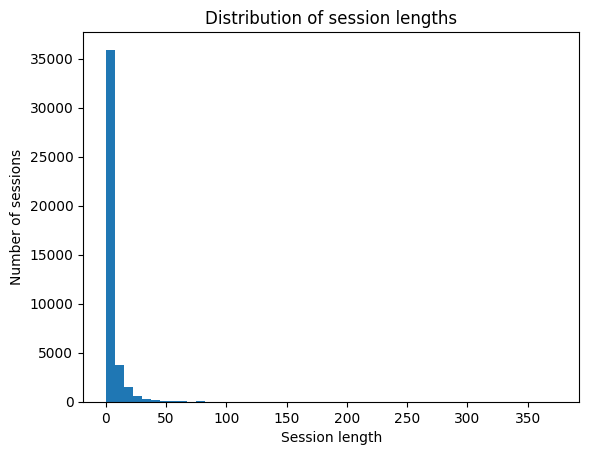

In [ ]:
import matplotlib.pyplot as plt

session_lengths = [len(ev) for ev in df['events_parsed']]

plt.hist(session_lengths, bins=50)
plt.xlabel("Session length")
plt.ylabel("Number of sessions")
plt.title("Distribution of session lengths")
plt.show()

In [ ]:
lengths = np.array(session_lengths)
print(np.percentile(lengths, [50, 90, 95, 99, 100]))


[  2.  11.  17.  40. 374.]


In [ ]:
# 3) Feature encoding utilities
MAX_SEQ_LEN = 64  # 128 -> 64 | percentile[50, 90, 95, 99, 100] = [  2.  11.  17.  40. 374.] 
def map_cat(value, vocab_map):
    if value is None:
        return vocab_map.get('<OOV>', 1)
    s = str(value)
    if s in vocab_map:
        return vocab_map[s]
    else:
        return vocab_map.get('<OOV>', 1)

# prepare numeric scaler: compute from flattened events
all_nums = {f: [] for f in num_fields}
for ev_list in df['events_parsed']:
    for ev in ev_list:
        for nf in num_fields:
            val = ev.get(nf, 0.0)
            if val is None:
                val = 0.0
            all_nums[nf].append(float(val))

scalers = {}
for nf in num_fields:
    scaler = StandardScaler()
    vals = np.array(all_nums[nf]).reshape(-1, 1)
    scaler.fit(vals)
    scalers[nf] = scaler

In [ ]:
# 4) Convert each session to fixed tensors (padded/truncated)
def session_to_features(ev_list):
    seq_len = min(len(ev_list), MAX_SEQ_LEN)
    cat_indices = {f: np.zeros(MAX_SEQ_LEN, dtype=np.int32) for f in cat_fields}
    num_values = np.zeros((MAX_SEQ_LEN, len(num_fields)), dtype=np.float32)
    mask = np.zeros((MAX_SEQ_LEN,), dtype=np.float32)
    for i in range(seq_len):
        ev = ev_list[-seq_len+i] # max_seq_len 초과하는 세션은 뒤에서 자르기(if 0~100, max_seq_len=64 -> 36~100) 앞부터 자르려면 ev = ev_list[i]
        mask[i] = 1.0
        for f in cat_fields:
            cat_indices[f][i] = map_cat(ev.get(f, 'unknown'), vocab[f])
        # numeric
        for j, nf in enumerate(num_fields):
            val = ev.get(nf, 0.0)
            if val is None:
                val = 0.0
            # scale
            scaled = scalers[nf].transform(np.array([[float(val)]]))[0,0]
            num_values[i, j] = scaled
    return cat_indices, num_values, mask

# Example transform on first few sessions
sample = df['events_parsed'].iloc[0]
cat_idx, num_vals, mask = session_to_features(sample)
print({k: v.shape for k, v in cat_idx.items()}, num_vals.shape, mask.sum())

{'event_type': (64,), 'category_code': (64,), 'general_category': (64,), 'brand': (64,)} (64, 4) 1.0


In [ ]:
# 5) Build tf.data pipeline
def gen():
    for _, row in df.iterrows():
        cat_idx, num_vals, mask = session_to_features(row['events_parsed'])
        # combine categorical indices into a dict or stacked array
        # We'll return a dict for clarity
        features = {f: cat_idx[f] for f in cat_fields}
        features['numeric'] = num_vals
        features['mask'] = mask
        label = np.array([row['buy']], dtype=np.float32)
        yield features, label

# define output signature for tf.data
output_signature = (
    {
        **{f: tf.TensorSpec(shape=(MAX_SEQ_LEN,), dtype=tf.int32) for f in cat_fields},
        'numeric': tf.TensorSpec(shape=(MAX_SEQ_LEN, len(num_fields)), dtype=tf.float32),
        'mask': tf.TensorSpec(shape=(MAX_SEQ_LEN,), dtype=tf.float32)
    },
    tf.TensorSpec(shape=(1,), dtype=tf.float32)
)

dataset = tf.data.Dataset.from_generator(gen, output_signature=output_signature)
dataset = dataset.shuffle(2048).batch(64).prefetch(tf.data.AUTOTUNE)

# split into train/val manually (for simplicity)
train_df, val_df = train_test_split(df, test_size=0.1, random_state=42, stratify=df['buy'])
def make_ds_from_df(df_sub):
    def gen_sub():
        for _, row in df_sub.iterrows():
            cat_idx, num_vals, mask = session_to_features(row['events_parsed'])
            features = {f: cat_idx[f] for f in cat_fields}
            features['numeric'] = num_vals
            features['mask'] = mask
            label = np.array([row['buy']], dtype=np.float32)
            yield features, label
    return tf.data.Dataset.from_generator(gen_sub, output_signature=output_signature).batch(64).prefetch(tf.data.AUTOTUNE)

train_ds = make_ds_from_df(train_df)
val_ds = make_ds_from_df(val_df)

In [ ]:
# 6) Build Transformer-based model in Keras
# helper: create embedding layers for each categorical feature
EMBED_DIM = 32
cat_emb_layers = {}
for f in cat_fields:
    vocab_size = len(vocab[f]) + 1  # plus pad maybe
    cat_emb_layers[f] = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=EMBED_DIM, mask_zero=True, name=f'emb_{f}')

# positional encoding (simple learned)
pos_emb = tf.keras.layers.Embedding(input_dim=MAX_SEQ_LEN, output_dim=EMBED_DIM, name='pos_emb')

class TransformerEncoderBlock(tf.keras.layers.Layer):
    def __init__(self, dim, num_heads, mlp_dim, dropout=0.1, **kwargs): # add **kwargs for saving and loading model
        super().__init__(**kwargs) # add **kwargs for saving and loading model
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=dim)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(mlp_dim, activation='relu'),
            tf.keras.layers.Dense(dim),
        ])
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, x, mask=None, training=False):
        # mask: [batch, seq_len] float mask -> convert to attention mask
        attn_mask = None
        if mask is not None:
            # MultiHeadAttention takes boolean mask where True means keep (opposite behavior), or attention_mask with shape [batch, seq_len]?
            # We'll create a 2D key mask: shape (batch, seq_len)
            # Keras MultiHeadAttention supports attention_mask (boolean) shape [batch, seq_len]
            attn_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.bool)  # shape (batch,1,seq)
        attn_out = self.mha(x, x, attention_mask=attn_mask)
        attn_out = self.dropout1(attn_out, training=training)
        out1 = self.norm1(x + attn_out)
        ff = self.ffn(out1)
        ff = self.dropout2(ff, training=training)
        out2 = self.norm2(out1 + ff)
        return out2

def build_model():
    # inputs
    inputs = {f: tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32, name=f) for f in cat_fields}
    inputs['numeric'] = tf.keras.Input(shape=(MAX_SEQ_LEN, len(num_fields)), dtype=tf.float32, name='numeric')
    inputs['mask'] = tf.keras.Input(shape=(MAX_SEQ_LEN,), dtype=tf.float32, name='mask')

    # embed categorical and sum embeddings (or concat)
    emb_list = []
    for f in cat_fields:
        e = cat_emb_layers[f](inputs[f])  # (batch, seq, emb)
        emb_list.append(e)
        
    # project numeric features to embedding space
    numeric_proj = tf.keras.layers.Dense(EMBED_DIM)(inputs['numeric'])  # (batch, seq, emb)
    emb_list.append(numeric_proj)

    x = tf.keras.layers.Add()(emb_list)  # element-wise sum of embeddings
    # add position embedding
    positions = tf.range(start=0, limit=MAX_SEQ_LEN, delta=1)
    pos_embeddings = pos_emb(positions)
    x = x + pos_embeddings  # broadcast adds position to every batch

    # apply mask (pass to encoder blocks)
    mask = inputs['mask']

    # stack Transformer encoder blocks
    for _ in range(2):  # num encoder layers, tune as needed
        x = TransformerEncoderBlock(dim=EMBED_DIM, num_heads=4, mlp_dim=EMBED_DIM*4)(x, mask=mask)

    # pooling: use masked mean pooling
    mask_expanded = tf.keras.layers.Lambda(lambda m: tf.expand_dims(m, axis=-1))(mask)  # (batch, seq, 1)
    x_masked = tf.keras.layers.Multiply()([x, mask_expanded])
    sum_x = tf.keras.layers.Lambda(lambda z: tf.reduce_sum(z, axis=1))(x_masked)  # (batch, emb)
    lengths = tf.keras.layers.Lambda(lambda m: tf.reduce_sum(m, axis=1))(mask_expanded)  # (batch,1)
    pooled = tf.keras.layers.Lambda(lambda z: z[0] / (z[1] + 1e-6))([sum_x, lengths])
    
    # classifier head
    h = tf.keras.layers.Dense(64, activation='relu')(pooled)
    h = tf.keras.layers.Dropout(0.3)(h)
    out = tf.keras.layers.Dense(1, activation='sigmoid', name='buy_prob')(h)

    model = tf.keras.Model(inputs=inputs, outputs=out)
    return model

model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.BinaryAccuracy(name='acc')])
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ event_type          │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ category_code       │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ general_category    │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ brand (InputLayer)  │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numeric             │ (None, 64, 4)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_event_type      │ (None, 64, 32)    │        128 │ event_type[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_category_code   │ (None, 64, 32)    │      4,000 │ category_code[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_general_catego… │ (None, 64, 32)    │        512 │ general_category… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb_brand           │ (None, 64, 32)    │     59,552 │ brand[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64, 32)    │        160 │ numeric[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 32)    │          0 │ emb_event_type[0… │
│                     │                   │            │ emb_category_cod… │
│                     │                   │            │ emb_general_cate… │
│                     │                   │            │ emb_brand[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 64, 32)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mask (InputLayer)   │ (None, 64)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 64, 32)    │     25,280 │ add_1[0][0],      │
│ (TransformerEncode… │                   │            │ mask[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, 64, 32)    │     25,280 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ mask[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64, 1)     │          0 │ mask[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 64, 32)    │          0 │ transformer_enco… │
│                     │                   │            │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 117,089 (457.38 KB)

 Trainable params: 117,089 (457.38 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 7) Train
# Option: compute class weights if imbalanced
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

labels = df['buy'].values
pos = labels.sum()
neg = len(labels) - pos
class_weight = {0: 1.0, 1: (neg / (pos + 1e-6))}  # simple balancing, 1e-6은 0으로 나누는 오류 방지용 아주 작은 수

early_stop = EarlyStopping(
    monitor='val_auc', # val_loss -> val_auc
    patience=3, # 개선 없으면 3 epoch 후 중단
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    'best_model.keras',  # best_model.h5 -> best_model.keras
    # WARNING:absl:You are saving your model as an HDF5 file via `model.save()` or `keras.saving.save_model(model)`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')` or `keras.saving.save_model(model, 'my_model.keras')`.
    monitor='val_auc',
    save_best_only=True,
    mode='max'
)

# fit
epochs = 15
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, class_weight=class_weight, callbacks=[early_stop,checkpoint])

Epoch 1/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 110s 175ms/step - acc: 0.6077 - auc: 0.6038 - loss: 1.3226 - val_acc: 0.7443 - val_auc: 0.7445 - val_loss: 0.5941
Epoch 2/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 106s 177ms/step - acc: 0.7666 - auc: 0.7715 - loss: 1.1002 - val_acc: 0.7732 - val_auc: 0.7677 - val_loss: 0.5384
Epoch 3/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 128s 215ms/step - acc: 0.8131 - auc: 0.8212 - loss: 0.9897 - val_acc: 0.7234 - val_auc: 0.7700 - val_loss: 0.5682
Epoch 4/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 146s 245ms/step - acc: 0.8321 - auc: 0.8453 - loss: 0.9336 - val_acc: 0.7697 - val_auc: 0.7756 - val_loss: 0.5247
Epoch 5/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 146s 245ms/step - acc: 0.8302 - auc: 0.8587 - loss: 0.8996 - val_acc: 0.7368 - val_auc: 0.7732 - val_loss: 0.5563
Epoch 6/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 147s 246ms/step - acc: 0.8330 - auc: 0.8657 - loss: 0.8780 - val_acc: 0.8083 - val_auc: 0.7792 - val_loss: 0.4757
Epoch 7/15
598/598 ━━━━━━━━━━━━━━━━━━━━ 165s 185ms/step - acc: 0.8354 - auc:

In [ ]:
# 8) Evaluate and inference
# example inference on raw session
def predict_session(model, ev_list):
    cat_idx, num_vals, mask = session_to_features(ev_list)
    feed = {f: np.expand_dims(cat_idx[f], 0) for f in cat_fields}
    feed['numeric'] = np.expand_dims(num_vals, 0)
    feed['mask'] = np.expand_dims(mask, 0)
    prob = model.predict(feed)[0,0]
    return prob 

In [ ]:
example_session = [
    {
        "event_type": 2, 
        "product_id": 22200103, 
        "category_code": "electronics.smartphone",
        "general_category": "electronics",
        "brand": "samsung",
        "price": 350.0,
        "relative_price": 0.45,
        "time_since_start": 0.0,
        "time_since_prev": 0.0
    },
    {
        "event_type": 2, 
        "product_id": 6902133, 
        "category_code": "computers.notebook",
        "general_category": "computers",
        "brand": "apple",
        "price": 1200.0,
        "relative_price": 0.9,
        "time_since_start": 30.0,
        "time_since_prev": 30.0
    }
]

prob = predict_session(model, example_session)
print(f"구매 확률: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
구매 확률: 0.3299


In [ ]:
example_session = [
    {
        "event_type": 2, 
        "product_id": 22200103, 
        "category_code": "electronics.smartphone",
        "general_category": "electronics",
        "brand": "samsung",
        "price": 350.0,
        "relative_price": 0.45,
        "time_since_start": 0.0,
        "time_since_prev": 0.0
    },
    {
        "event_type": 2, 
        "product_id": 6902133, 
        "category_code": "computers.notebook",
        "general_category": "computers",
        "brand": "apple",
        "price": 1200.0,
        "relative_price": 0.9,
        "time_since_start": 14.0,
        "time_since_prev": 14.0
    },
    {
        "event_type": 2, 
        "product_id": 22200103, 
        "category_code": "electronics.smartphone",
        "general_category": "electronics",
        "brand": "samsung",
        "price": 350.0,
        "relative_price": 0.45,
        "time_since_start": 27.0,
        "time_since_prev": 13.0
    },
    {
        "event_type": 1, 
        "product_id": 22200103, 
        "category_code": "electronics.smartphone",
        "general_category": "electronics",
        "brand": "samsung",
        "price": 350.0,
        "relative_price": 0.45,
        "time_since_start": 28.0,
        "time_since_prev": 1.0
    }
]

prob = predict_session(model, example_session)
print(f"구매 확률: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
구매 확률: 0.3245


In [ ]:
example_session = [
    {
        "event_type": 2, 
        "product_id": 22200103, 
        "category_code": "electronics.smartphone",
        "general_category": "electronics",
        "brand": "samsung",
        "price": 350.0,
        "relative_price": 0.45,
        "time_since_start": 0.0,
        "time_since_prev": 0.0
    },
    {
        "event_type": 2, 
        "product_id": 6902133, 
        "category_code": "computers.notebook",
        "general_category": "computers",
        "brand": "apple",
        "price": 1200.0,
        "relative_price": 0.9,
        "time_since_start": 14.0,
        "time_since_prev": 14.0
    },
    {
        "event_type": 2, 
        "product_id": 22200103, 
        "category_code": "electronics.smartphone",
        "general_category": "electronics",
        "brand": "samsung",
        "price": 350.0,
        "relative_price": 0.45,
        "time_since_start": 27.0,
        "time_since_prev": 13.0
    }
]

prob = predict_session(model, example_session)
print(f"구매 확률: {prob:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
구매 확률: 0.2919


In [ ]:
print(log_dict.iloc[7]['event'])

[{'event_type': np.int64(2), 'product_id': 17301541, 'category_code': 'unknown.', 'general_category': 'unknown', 'brand': 'unknown', 'price': 162.17, 'relative_price': 1.8000888000887998, 'time_since_start': 0.0, 'time_since_prev': 0}, {'event_type': np.int64(2), 'product_id': 17301541, 'category_code': 'unknown.', 'general_category': 'unknown', 'brand': 'unknown', 'price': 162.17, 'relative_price': 1.8000888000887998, 'time_since_start': 25.0, 'time_since_prev': 25.0}]


In [ ]:
prob = predict_session(model, log_dict.iloc[7]['event'])
print(f"구매 확률: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
구매 확률: 0.5572


In [ ]:
len(log_dict)

42509

In [ ]:
import random
randlist = random.sample(range(len(log_dict)), 5)
randlist

[20315, 37814, 5924, 8704, 41910]

In [ ]:
for i  in randlist:
    prob = predict_session(model, log_dict.iloc[i]['event'])
    print(i)
    print(f"Index {i} 구매 확률: {prob:.4f}")
    print("-"*42)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
20315
Index 20315 구매 확률: 0.0219
------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
37814
Index 37814 구매 확률: 0.8390
------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
5924
Index 5924 구매 확률: 0.6046
------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
8704
Index 8704 구매 확률: 0.0157
------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
41910
Index 41910 구매 확률: 0.0954
------------------------------------------


In [ ]:
print(log_dict.iloc[17924]['event'])

[{'event_type': np.int64(2), 'product_id': 21407370, 'category_code': 'electronics.clocks', 'general_category': 'electronics', 'brand': 'casio', 'price': 162.17, 'relative_price': 0.642130271233419, 'time_since_start': 0.0, 'time_since_prev': 0}, {'event_type': np.int64(2), 'product_id': 21400403, 'category_code': 'electronics.clocks', 'general_category': 'electronics', 'brand': 'boccia', 'price': 87.52, 'relative_price': 0.34654523856662045, 'time_since_start': 312.0, 'time_since_prev': 312.0}]


In [ ]:
print(log_dict[log_dict['buy'] == 1]['session'])

88          88
89          89
236        236
443        443
446        446
         ...  
42476    42476
42478    42478
42494    42494
42496    42496
42502    42502
Name: session, Length: 1228, dtype: int64


In [ ]:
prob = predict_session(model, log_dict.iloc[42476]['event'])
print(f"구매 확률: {prob:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
구매 확률: 0.8149
